# Download Dataset

In [ ]:
import gdown

In [ ]:
!mkdir ./dataset

In [ ]:
cd dataset

In [ ]:
# info
id1 = "1cqfcs-7XXhh_kqIUPEde-lY6I9COUsjC"
gdown.download(id=id1, quiet=False)

# Train-val zip
id2 = "1YWjUODQWwQ3_vKSytqVdF4recqBOEe72"
gdown.download(id=id2, quiet=False)

# test zip
id3 = "1diN3tNe2nR1eV3Px4gqlp6wp3XuLBwDy"
gdown.download(id=id3, quiet=False)

In [ ]:
# unzip dataset

from glob import glob
import zipfile

files = glob('*.zip')

for file in files:
    print('Unzipping:',file)

    with zipfile.ZipFile(file, 'r') as zip_ref:
        zip_ref.extractall('./')


In [ ]:
!rm -rf train_val.zip
!rm -rf TEST.zip

In [ ]:
cd ..

In [ ]:
# split random val and train 
import os
import shutil
import random

# Define the path to the dataset
dataset_base_path = './dataset'  
images_path = os.path.join(dataset_base_path, 'train_val/images')
masks_path = os.path.join(dataset_base_path, 'train_val/masks')

# Define the path for the train and val directories
train_images_path = os.path.join(dataset_base_path, 'train/images')
train_masks_path = os.path.join(dataset_base_path, 'train/masks')
val_images_path = os.path.join(dataset_base_path, 'val/images')
val_masks_path = os.path.join(dataset_base_path, 'val/masks')

# Create directories if they don't exist
for path in [train_images_path, train_masks_path, val_images_path, val_masks_path]:
    os.makedirs(path, exist_ok=True)

# Get the list of image files
image_files = [f for f in os.listdir(images_path) if f.endswith('.jpg')]

# Shuffle and split the dataset
random.shuffle(image_files)
split_ratio = 0.9  
split_index = int(len(image_files) * split_ratio)

train_files = image_files[:split_index]
val_files = image_files[split_index:]

# Move the files to the respective directories
for file in train_files:
    shutil.move(os.path.join(images_path, file), train_images_path)
    shutil.move(os.path.join(masks_path, file.replace('.jpg', '.bmp')), train_masks_path)

for file in val_files:
    shutil.move(os.path.join(images_path, file), val_images_path)
    shutil.move(os.path.join(masks_path, file.replace('.jpg', '.bmp')), val_masks_path)

# Ensure to replace 'path_to_your_dataset' with the actual path to your dataset.


# Import libraries

In [1]:
import os
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
import numpy as np 

import matplotlib.pyplot as plt
import random

import torchvision.transforms.functional as TF
import cv2 

import torch.nn as nn
import torch.nn.functional as F


/root/miniconda3/envs/torch2/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Prepare Dataset

In [7]:
class SegmentationDataset(Dataset):
    def __init__(self, images_dir, masks_dir, transform=None, target_transform=None, augmentation_factor=10, apply_augmentation=False):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.transform = transform
        self.target_transform = target_transform
        self.augmentation_factor = augmentation_factor
        self.apply_augmentation = apply_augmentation
        self.images = [f for f in os.listdir(images_dir) if f.endswith('.jpg')]

    def __len__(self):
        return len(self.images) * self.augmentation_factor

    def __getitem__(self, idx):
        original_idx = idx % len(self.images)
        augment = idx >= len(self.images)

        image_path = os.path.join(self.images_dir, self.images[original_idx])
        mask_path = os.path.join(self.masks_dir, self.images[original_idx].replace('.jpg', '.bmp'))

        image = Image.open(image_path).convert("RGB")
        mask = Image.open(mask_path)

        if self.apply_augmentation:
            image, mask = self.apply_transforms(image, mask)

        if self.transform is not None:
            image = self.transform(image)

        # Convert mask to class labels
        mask = self.convert_mask(mask)

        # Convert the NumPy array back to a PIL Image for target_transform
        mask = Image.fromarray(mask.astype(np.uint8))

        if self.target_transform is not None:
            mask = self.target_transform(mask)
        else:
            mask = torch.tensor(mask, dtype=torch.long)
        return image, mask
    

    def apply_transforms(self, image, mask):
        # Random horizontal flipping with 50% probability
        if random.random() > 0.5:
            image = TF.hflip(image)
            mask = TF.hflip(mask)

        # Random rotation with 50% probability
        if random.random() > 0.5:
            angle = random.uniform(-20, 20)
            image = TF.rotate(image, angle)
            mask = TF.rotate(mask, angle, fill=0)

        # Random affine transformations (shear, zoom, width/height shift) with 50% probability
        if random.random() > 0.5:
            translate = (random.uniform(-0.05, 0.05), random.uniform(-0.05, 0.05))
            scale = random.uniform(1 - 0.05, 1 + 0.05)
            shear = random.uniform(-0.05, 0.05)
            image = TF.affine(image, angle=0, translate=translate, scale=scale, shear=shear)
            mask = TF.affine(mask, angle=0, translate=translate, scale=scale, shear=shear, fill=0)

        return image, mask

    def convert_mask(self, mask):
        mapping = {
            (0, 0, 0): 0,
            (0, 0, 255): 1,
            (0, 255, 0): 2,
            (0, 255, 255): 3,
            (255, 0, 0): 4,
            (255, 0, 255): 5,
            (255, 255, 0): 6,
            (255, 255, 255): 7
        }
        mask = np.array(mask)
        class_map = np.zeros(mask.shape[:2], dtype=np.int32)
        for rgb, idx in mapping.items():
            class_map[(mask == rgb).all(axis=2)] = idx
        return class_map


In [9]:
# Define the image transformations
transform = transforms.Compose([
    transforms.Resize((160, 160)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

target_transform = transforms.Compose([
    transforms.Resize((160, 160), interpolation=Image.NEAREST),
    transforms.Lambda(lambda x: torch.tensor(np.array(x), dtype=torch.long))
])

# Load the training dataset with augmentation
train_dataset = SegmentationDataset('dataset/train/images', 'dataset/train/masks', 
                                   transform=transform, target_transform=target_transform, 
                                   augmentation_factor=4, apply_augmentation=True)

# Load the validation dataset without augmentation
val_dataset = SegmentationDataset('dataset/val/images', 'dataset/val/masks', 
                                  transform=transform, target_transform=target_transform, 
                                  augmentation_factor=1, apply_augmentation=False)


# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=1)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=1)



len(train_loader)

/tmp/ipykernel_90724/2566437581.py:9: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  transforms.Resize((160, 160), interpolation=Image.NEAREST),


343

In [10]:
len(val_loader)

10

In [11]:
for i , l in train_loader:
    print(i.shape)
    print(l.shape)
    break

torch.Size([16, 3, 160, 160])
torch.Size([16, 160, 160])


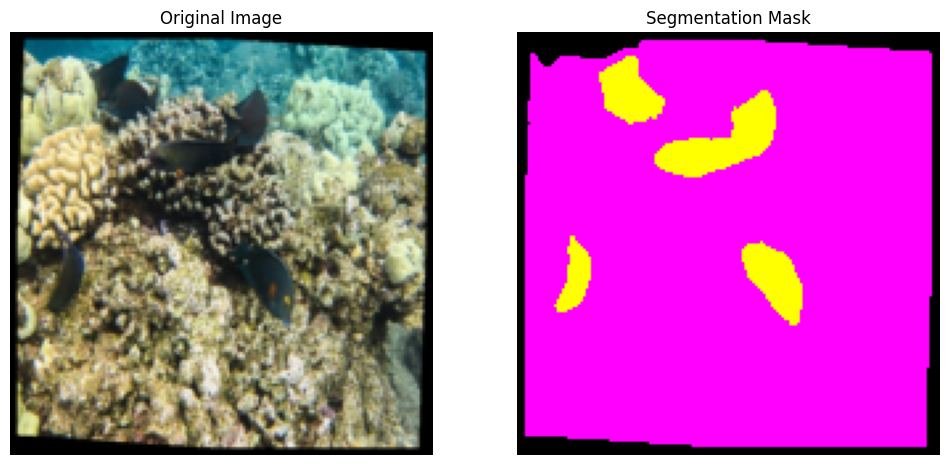

In [17]:
# Function to convert a torch tensor to a numpy array
def to_numpy(tensor):
    return tensor.cpu().detach().numpy()

# Function to reverse the class labels to RGB
def labels_to_rgb(mask):
    label_colors = {
        0: [0, 0, 0],      # Background waterbody
        1: [0, 0, 255],    # Human divers
        2: [0, 255, 0],    # Plants/sea-grass
        3: [0, 255, 255],  # Wrecks/ruins
        4: [255, 0, 0],    # Robots/instruments
        5: [255, 0, 255],  # Reefs and invertebrates
        6: [255, 255, 0],  # Fish and vertebrates
        7: [255, 255, 255] # Sand/sea-floor (& rocks)
    }
    rgb_image = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
    for label, color in label_colors.items():
        rgb_image[mask == label] = color
    return rgb_image

# Get a random batch from the train_loader
images, masks = next(iter(train_loader))

# Choose a random image and mask from the batch
idx = random.randint(0, images.shape[0] - 1)
image = to_numpy(images[idx])
mask = to_numpy(masks[idx])

# Normalize image for visualization
image = np.transpose(image, (1, 2, 0))  # Change from CHW to HWC format
# Reversing the normalization
image = image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
image = np.clip(image, 0, 1)

# Convert labels to RGB
mask_rgb = labels_to_rgb(mask)

# Plot the image and the mask separately
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(mask_rgb)  # Display the mask separately
plt.title('Segmentation Mask')
plt.axis('off')

plt.show()

# Implement U-NET

In [18]:

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super(DoubleConv, self).__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = DoubleConv(64, 128)
        self.down2 = DoubleConv(128, 256)
        self.down3 = DoubleConv(256, 512)
        self.up1 = DoubleConv(512 + 256, 256)  # Adjusted channels for concatenation
        self.up2 = DoubleConv(256 + 128, 128)
        self.up3 = DoubleConv(128 + 64, 64)
        self.outc = nn.Conv2d(64, n_classes, kernel_size=1)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = F.max_pool2d(x1, 2)
        x3 = self.down1(x2)
        x4 = F.max_pool2d(x3, 2)
        x5 = self.down2(x4)
        x6 = F.max_pool2d(x5, 2)
        x7 = self.down3(x6)
        x8 = F.interpolate(x7, scale_factor=2, mode='bilinear', align_corners=True)
        x8 = torch.cat([x8, x5], dim=1)
        x9 = self.up1(x8)
        x10 = F.interpolate(x9, scale_factor=2, mode='bilinear', align_corners=True)
        x10 = torch.cat([x10, x3], dim=1)
        x11 = self.up2(x10)
        x12 = F.interpolate(x11, scale_factor=2, mode='bilinear', align_corners=True)
        x12 = torch.cat([x12, x1], dim=1)
        x13 = self.up3(x12)
        logits = self.outc(x13)
        return logits


In [19]:
def calculate_miou(preds, labels, num_classes):
    iou_list = []
    preds = torch.argmax(preds, dim=1)
    for cls in range(num_classes):
        pred_inds = (preds == cls)
        target_inds = (labels == cls)
        intersection = (pred_inds[target_inds]).long().sum().item()  # Intersection
        union = pred_inds.long().sum().item() + target_inds.long().sum().item() - intersection  # Union
        if union == 0:
            iou = float('nan')  # Avoid zero division
        else:
            iou = float(intersection) / float(max(union, 1))
        iou_list.append(iou)
    return np.nanmean(iou_list)  # Return the average IoU

In [20]:
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR


device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Parameters
n_channels = 3 
n_classes = 8 
lr = 0.0001 
n_epochs = 100

# Model, optimizer, and loss function
model = UNet(n_channels, n_classes).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = StepLR(optimizer, step_size=50, gamma=0.1)

criterion = nn.CrossEntropyLoss()

Using device: cuda:1


In [ ]:
from tqdm import tqdm
# Initialize the best validation mIoU
best_val_miou = 0.0


# Define the directory and filename for saving the model
model_save_path = 'models'
os.makedirs(model_save_path, exist_ok=True)
# Define the filename for saving the best model
best_model_filename = 'best_Unet.pth'

# Initialize lists to store metrics
train_losses = []
val_losses = []
train_miou = []
val_miou = []

early_stop_patience = 8 
early_stop_counter = 0 

# Training loop
for epoch in range(n_epochs):
    model.train()
    total_train_loss = 0.0
    total_train_iou = 0.0

    for images, masks in tqdm(train_loader):
        # Move data to device
        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        total_train_iou += calculate_miou(outputs, masks, n_classes)

    avg_train_loss = total_train_loss / len(train_loader)
    avg_train_iou = total_train_iou / len(train_loader)
    train_losses.append(avg_train_loss)
    train_miou.append(avg_train_iou)
    
    scheduler.step()

    # Validation loop
    model.eval()
    total_val_loss = 0.0
    total_val_iou = 0.0

    with torch.no_grad():
        for images, masks in val_loader:
            # Move data to device
            images, masks = images.to(device), masks.to(device)

            outputs = model(images)
            loss = criterion(outputs, masks)
            total_val_loss += loss.item()
            total_val_iou += calculate_miou(outputs, masks, n_classes)

    avg_val_loss = total_val_loss / len(val_loader)
    avg_val_iou = total_val_iou / len(val_loader)
    val_losses.append(avg_val_loss)
    val_miou.append(avg_val_iou)

    print(f'Epoch {epoch+1}, Train Loss: {avg_train_loss}, Train mIoU: {avg_train_iou}, Val Loss: {avg_val_loss}, Val mIoU: {avg_val_iou}')
    
    # Check if the current validation mIoU is the best one
    if avg_val_iou > best_val_miou:
        print(f"New best validation mIoU: {avg_val_iou} at epoch {epoch+1}")
        best_val_miou = avg_val_iou

        # Save the model
        best_save_path = os.path.join(model_save_path, best_model_filename)
        torch.save(model.state_dict(), best_save_path)
        print(f"Best model saved to {best_save_path}")
        
        early_stop_counter = 0
    else:
        # Increment early stopping counter
        early_stop_counter += 1

    # Check if training should be stopped early
    if early_stop_counter >= early_stop_patience:
        print(f"Early stopping at epoch {epoch+1} due to no improvement in validation mIoU for {early_stop_patience} consecutive epochs.")
        break

100%|██████████| 343/343 [07:52<00:00,  1.38s/it]


Epoch 1, Train Loss: 1.2314759266967328, Train mIoU: 0.22042463312044125, Val Loss: 1.052185845375061, Val mIoU: 0.24480136404455002
New best validation mIoU: 0.24480136404455002 at epoch 1
Best model saved to models/best_Unet.pth


100%|██████████| 343/343 [07:50<00:00,  1.37s/it]


Epoch 2, Train Loss: 1.0104279111495171, Train mIoU: 0.27484050383742153, Val Loss: 0.8953771531581879, Val mIoU: 0.3002836290756462
New best validation mIoU: 0.3002836290756462 at epoch 2
Best model saved to models/best_Unet.pth


100%|██████████| 343/343 [07:52<00:00,  1.38s/it]


Epoch 3, Train Loss: 0.929843630630838, Train mIoU: 0.30890951309533254, Val Loss: 0.8396594107151032, Val mIoU: 0.302848569956881
New best validation mIoU: 0.302848569956881 at epoch 3
Best model saved to models/best_Unet.pth


100%|██████████| 343/343 [07:51<00:00,  1.37s/it]


Epoch 4, Train Loss: 0.8621931470517862, Train mIoU: 0.3411261880040821, Val Loss: 0.8008789837360382, Val mIoU: 0.32089219774369276
New best validation mIoU: 0.32089219774369276 at epoch 4
Best model saved to models/best_Unet.pth


100%|██████████| 343/343 [07:51<00:00,  1.37s/it]


Epoch 5, Train Loss: 0.8155875990585405, Train mIoU: 0.36484509885493915, Val Loss: 0.7775573134422302, Val mIoU: 0.32077928411516937


100%|██████████| 343/343 [07:49<00:00,  1.37s/it]


Epoch 6, Train Loss: 0.7778454127534138, Train mIoU: 0.3816261581036504, Val Loss: 0.7315515756607056, Val mIoU: 0.33478796356655643
New best validation mIoU: 0.33478796356655643 at epoch 6
Best model saved to models/best_Unet.pth


100%|██████████| 343/343 [07:52<00:00,  1.38s/it]


Epoch 7, Train Loss: 0.7429283646209595, Train mIoU: 0.3938810532219218, Val Loss: 0.6893457293510437, Val mIoU: 0.3453837435025392
New best validation mIoU: 0.3453837435025392 at epoch 7
Best model saved to models/best_Unet.pth


100%|██████████| 343/343 [07:53<00:00,  1.38s/it]


Epoch 8, Train Loss: 0.7128912538898234, Train mIoU: 0.41260894418077104, Val Loss: 0.7492694199085236, Val mIoU: 0.3517027626735705
New best validation mIoU: 0.3517027626735705 at epoch 8
Best model saved to models/best_Unet.pth


100%|██████████| 343/343 [07:53<00:00,  1.38s/it]


Epoch 9, Train Loss: 0.6757666201007609, Train mIoU: 0.4313670115704768, Val Loss: 0.6959364712238312, Val mIoU: 0.3483389320494068


100%|██████████| 343/343 [07:49<00:00,  1.37s/it]


Epoch 10, Train Loss: 0.6543613302116839, Train mIoU: 0.43488724213827623, Val Loss: 0.7148328065872193, Val mIoU: 0.3541053517567482
New best validation mIoU: 0.3541053517567482 at epoch 10
Best model saved to models/best_Unet.pth


100%|██████████| 343/343 [07:47<00:00,  1.36s/it]


Epoch 11, Train Loss: 0.6131595463516414, Train mIoU: 0.4614435922925254, Val Loss: 0.6455217957496643, Val mIoU: 0.37542590660673814
New best validation mIoU: 0.37542590660673814 at epoch 11
Best model saved to models/best_Unet.pth


 17%|█▋        | 58/343 [01:19<06:48,  1.43s/it]

In [ ]:
plt.figure(figsize=(12, 5))

# Plotting training and validation loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(val_miou, label='Val mIoU')
plt.title('Training & Validation mIoU')
plt.xlabel('Epochs')
plt.legend()

# Plotting training and validation mIoU
plt.subplot(1, 2, 2)
plt.plot(train_miou, label='Train mIoU')
plt.ylabel('mIoU')
plt.legend()

plt.show()

In [ ]:
# Define the path to the saved model
saved_model_path = os.path.join(model_save_path, 'best_Unet.pth')

# Make sure the model is in evaluation mode
model.load_state_dict(torch.load(saved_model_path))
model.eval()

In [ ]:
total_test_iou = 0.0

# Run the model on the test data
with torch.no_grad():
    for images, masks in test_loader:
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)
        total_test_iou += calculate_miou(outputs, masks, n_classes)

avg_test_iou = total_test_iou / len(test_loader)
print(f'Test mIoU: {avg_test_iou}')

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import random
import torch

def get_predictions(model, loader):
    images, _ = next(iter(loader))
    images = images.to(device)
    with torch.no_grad():
        preds = model(images)
    return images, preds

images, preds = get_predictions(model, test_loader)

for _ in range(10):  # Loop to visualize 10 random predictions
    idx = random.randint(0, images.shape[0] - 1)
    image = to_numpy(images[idx])
    pred = to_numpy(torch.argmax(preds[idx], dim=0))  # Convert predictions to label format

    # Normalize and clip image for visualization
    image = np.transpose(image, (1, 2, 0))
    image = image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    image = np.clip(image, 0, 1)

    # Convert predicted labels to RGB
    pred_rgb = labels_to_rgb(pred)

    # Plotting
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(pred_rgb)
    plt.title('Predicted Segmentation Mask')
    plt.axis('off')

    plt.show()
